# Intel TensorFlow AMX BF16 Inference

This notebook performs the following steps:

- Enable auto-mixed precision with few code changes for faster inference.
- Image Classification task using [TensorFlow Hub's](https://www.tensorflow.org/hub) ResNet50v1.5 pretrained model.
- Export the optimized model in the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.

In [1]:
# Importing libraries
import os
import numpy as np
import time
import PIL.Image as Image
import tensorflow as tf
#import tensorflow_hub as hub
from datetime import datetime
import requests
from copy import deepcopy
print("We are using Tensorflow version: ", tf.__version__)

2023-10-20 12:21:33.373006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We are using Tensorflow version:  2.13.0


### Identifying supported ISA

We identify the underlying supported ISA to determine whether to enable auto-mixed precision to leverage higher performance benefits for training and inference as accelerated by the 4th Gen Intel® Xeon® scalable processor (codenamed Sapphire Rapids).

In [2]:
# Check if hardware supports AMX

from cpuinfo import get_cpu_info
info = get_cpu_info()
flags = info['flags']
amx_supported = False
for flag in flags:
    if "amx" in flag:
        amx_supported = True
        print("AMX is supported on current hardware. Code sample can be run.\n")
if not amx_supported:
    print("AMX is not supported on current hardware. Code sample cannot be run.\n")
    sys.exit("AMX is not supported on current hardware. Code sample cannot be run.\n")

AMX is supported on current hardware. Code sample can be run.

AMX is supported on current hardware. Code sample can be run.

AMX is supported on current hardware. Code sample can be run.



If the message "AMX is not supported on current hardware. Code sample cannot be run." is printed above, the hardware being used does not support AMX. Therefore, this code sample cannot proceed.

### Image Classification with TensorFlow

In this section, we use [TensorFlow Hub's](https://www.tensorflow.org/hub) pretrained [ResNet50v1.5 pretrained model](https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5) trained on the ImageNet dataset and fine-tuned on TensorFlow Flower dataset.

Source: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

Loading the data in a *tf.data.Dataset* format.<br />
We use a Batch Size of 512 images each of shape 224 x 224 x 3.

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

batch_size = 512
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = np.array(train_ds.class_names)
print("The flower dataset has " + str(len(class_names)) + " classes: ", class_names)

Found 3670 files belonging to 5 classes.
Using 1835 files for training.
Found 3670 files belonging to 5 classes.
Using 1835 files for validation.
The flower dataset has 5 classes:  ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


2023-10-20 12:22:36.661359: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Image Pre-processing (Normalization between 0 and 1) and using buffered prefetching to avoid I/O blocking issues.

Reference: https://www.tensorflow.org/guide/data_performance#prefetching

In [4]:
# import pre-trained fp_32 model
fp32_model = tf.keras.models.load_model('models/my_saved_model_fp32')

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
import time
start = time.time()
fp32_history = fp32_model.evaluate(val_ds)
fp32_inference_time = time.time() - start

4/4 [==============================] - 8s 2s/step - loss: 0.4351 - acc: 0.8512


In [7]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(512, 224, 224, 3)
(512,)


### Enabling auto-mixed precision with `tf.config` API

In this section, we show how to enable the auto-mixed precision using the `tf.config` API. Enabling this API will automatically convert the pre-trained model to use the bfloat16 datatype for computation resulting in an increased inference throughput on the latest Intel® Xeon® scalable processor.


_Note: We only enable the auto-mixed precision if the underlying system is the 4th Gen Intel® Xeon® scalable processor (codenamed Sapphire Rapids)_

BF16 with AMX

In [8]:
# Reload the model as the bf16 model with AMX to compare inference time
os.environ["ONEDNN_MAX_CPU_ISA"] = "AMX_BF16"
tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
bf16_model_withAmx = tf.keras.models.load_model('models/my_saved_model_fp32')

bf16_model_withAmx_export_path = "models/my_saved_model_bf16_with_amx"
bf16_model_withAmx.save(bf16_model_withAmx_export_path)

2023-10-20 12:23:10.423106: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do


In [19]:
start = time.time()
bf16_withAmx_history = bf16_model_withAmx.evaluate(val_ds)
bf16_withAmx_inference_time = time.time() - start

4/4 [==============================] - 4s 1s/step - loss: 0.4350 - acc: 0.8512


BF16 with AVX512

In [21]:
%run -i 'AMX_BF16_with_AVX512.py'

We are using Tensorflow version:  2.13.0
Found 3670 files belonging to 5 classes.
Using 1835 files for training.
Found 3670 files belonging to 5 classes.
Using 1835 files for validation.


2023-10-20 12:27:15.007179: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:1502] No allowlist ops found, nothing to do
2023-10-20 12:27:17.261730: I tensorflow/core/grappler/optimizers/auto_mixed_precision.cc:2254] Converted 189/799 nodes to bfloat16 precision using 2 cast(s) to bfloat16 (excluding Const and Variable casts)


4/4 [==============================] - 6s 1s/step - loss: 0.4350 - acc: 0.8512
FP32 inference time: 8.179
BF16 with AVX512 inference time: 5.971


### Summary of Results

The following cells below will summarize the inference time for all three cases and display graphs to show the performance speedup.

In [22]:
print("Summary")
print("FP32 inference time: %.3f" %fp32_inference_time)
print("BF16 with AVX512 inference time: %.3f" %bf16_noAmx_inference_time)
print("BF16 with AMX inference time: %.3f" %bf16_withAmx_inference_time)

Summary
FP32 inference time: 8.179
BF16 with AVX512 inference time: 5.971
BF16 with AMX inference time: 5.137


<BarContainer object of 3 artists>

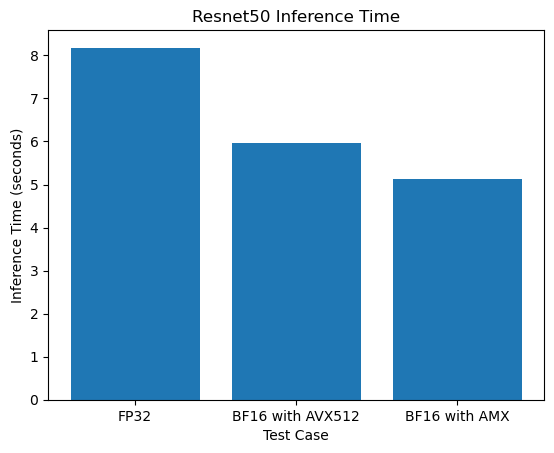

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Resnet50 Inference Time")
plt.xlabel("Test Case")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "BF16 with AVX512", "BF16 with AMX"], [fp32_inference_time, bf16_noAmx_inference_time, bf16_withAmx_inference_time])

In [24]:
speedup_bf16_noAMX_from_fp32 = fp32_inference_time / bf16_noAmx_inference_time
print("BF16 with AVX512 is %.2fX faster than FP32" %speedup_bf16_noAMX_from_fp32)
speedup_bf16_withAMX_from_fp32 = fp32_inference_time / bf16_withAmx_inference_time
print("BF16 with AMX is %.2fX faster than FP32" %speedup_bf16_withAMX_from_fp32)
speedup_bf16_withAMX_from_bf16 = bf16_noAmx_inference_time / bf16_withAmx_inference_time
print("BF16 with AMX is %.2fX faster than BF16 with AVX512" %speedup_bf16_withAMX_from_bf16)

BF16 with AVX512 is 1.37X faster than FP32
BF16 with AMX is 1.59X faster than FP32
BF16 with AMX is 1.16X faster than BF16 with AVX512


<BarContainer object of 3 artists>

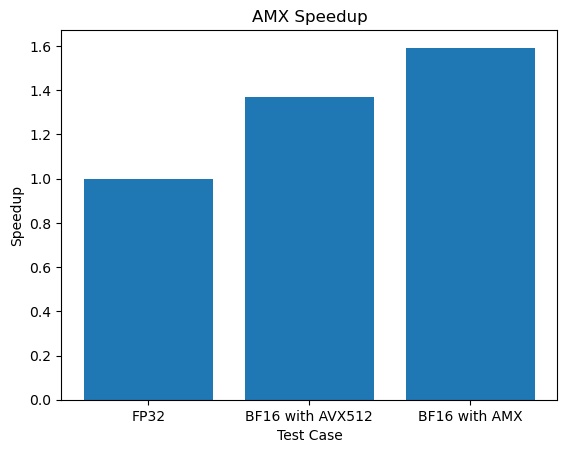

In [25]:
plt.figure()
plt.title("AMX Speedup")
plt.xlabel("Test Case")
plt.ylabel("Speedup")
plt.bar(["FP32", "BF16 with AVX512", "BF16 with AMX"], [1, speedup_bf16_noAMX_from_fp32, speedup_bf16_withAMX_from_fp32])

The following cell will summarize the inference accuracy for all three cases and illustrate the use of AMX BF16 with auto-mixed precision during inference will not influence the inference accuracy.

In [ ]:
fp32_inference_accuracy = fp32_history[1]
bf16_noAmx_inference_accuracy = bf16_noAmx_history[1]
bf16_withAmx_inference_accuracy = bf16_withAmx_history[1]
plt.figure()
plt.title("Resnet50 Inference Accuracy")
plt.xlabel("Test Case")
plt.ylabel("Inference Accuracy")
plt.bar(["FP32", "BF16 with AVX512", "BF16 with AMX"], [fp32_inference_accuracy, bf16_noAmx_inference_accuracy, bf16_withAmx_inference_accuracy])

In [ ]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')